# White-box classification to support explanation

The provenance grapk kernels introduced in [our paper](https://arxiv.org/abs/2010.10343) are compatible with white-box models. This notebook illustrates how they can help improve the explainability of classification decisions.

In [1]:
import csv
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz

from scripts.data.common import NETWORK_METRIC_NAMES
from scripts.experiments.common import read_kernel_dataframes, pd_df_to_coo

# sns.set_style("whitegrid")
sns.set_context("talk")

## Loading Data

In [2]:
# We looking at the dead label classification for the MIMIC dataset
dataset_id = "MIMIC-PXC7"
ROOT_DIR = Path(".")

In [3]:
dataset_folder = ROOT_DIR / "datasets" / dataset_id
outputs_folder = ROOT_DIR / "outputs" / dataset_id
graphs_index_filepath = outputs_folder / "graphs.pickled"
output_filepath = outputs_folder / "scoring.pickled"

In [4]:
graphs_index = pd.read_pickle(graphs_index_filepath)  # type: pd.Dataframe

In [17]:
# checking the balance of the "dead" label in the MIMIC dataset
graphs_index.dead.value_counts()

0    19599
1     2293
Name: dead, dtype: int64

In [6]:
graphs_index.head()

,graph_file,hadm_id,subject_id,drgcode_hcfa,drgcode_apr,drgcode_ms,first,last,will_return,returning,...,wasDerivedFrom,wasAttributedTo,wasAssociatedWith,actedOnBehalfOf,wasInfluencedBy,alternateOf,specializationOf,mentionOf,hadMember,timings_PNA
0,124321.json,124321,23,-1,212,25,True,True,False,False,...,7,0,8,0,0,0,1,0,0,0.565815
1,144319.json,144319,34,-1,1712,243,True,True,False,False,...,17,0,11,0,0,0,1,0,0,0.164238
2,165660.json,165660,36,-1,2273,353,True,True,False,False,...,28,0,17,0,0,0,1,0,0,0.318249
3,101651.json,101651,357,-1,1374,177,True,False,True,False,...,5,0,3,0,0,0,1,0,0,0.034556
4,117876.json,117876,357,-1,1304,207,False,True,False,True,...,40,0,24,0,0,0,1,0,0,0.650228


We select a balanced dataset from the MIMIC dataset and randomly split it into train and test set (at the ratio 7:3).

In [7]:
# Selecting a balanced subset of the data for the classification task
selected_graphs = graphs_index[graphs_index.dead == True]
selected_graphs = selected_graphs.append(
    graphs_index[graphs_index.dead == False].sample(len(selected_graphs), random_state=42)
)

In [8]:
selected_graphs.dead.value_counts()

0    2293
1    2293
Name: dead, dtype: int64

## Testing methods with Decision Tree Classifier

In [9]:
def train_test_plot_dt(X, y, feature_names, max_depth=3):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    
    # splitting the selected graphs to train and test set at the ratio 7:3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    clf.fit(X_train, y_train)
    # testing the trained classifier with the test set
    print("Accuracy:", clf.score(X_test, y_test))
    
    plt.figure(figsize=(18, 9))
    plot_tree(clf, feature_names=feature_names, filled=True, class_names=list(map(str, y.unique())))
    export_graphviz(clf, "plots/tree.dot", feature_names=feature_names, filled=True, class_names=list(map(str, y.unique())))
    return(clf)

In [10]:
def test_kernel(graphs, kernel_set, level, y_column):
    kernels_df = read_kernel_dataframes(outputs_folder, kernel_set=kernel_set, to_level=level)
    selected_kernels = kernels_df.loc[graphs.graph_file]
    
    X = pd_df_to_coo(selected_kernels)
    X = X.tocsr()
    y = graphs[y_column]
    
    train_test_plot_dt(X, y, kernels_df.columns)

In [11]:
def print_type_definition(kernels_folder: Path, type_name: str):
    kernel_set = type_name[:2]
    level = type_name[2]
    types_filepath = (
        kernels_folder / "kernels" / f"{kernel_set}_{level}_types.csv"
    )
    with types_filepath.open() as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            if row[0] == type_name:
                print(row[1])
                return
    print("[Not Found]")

## Testing A2

We train a decision tree classifier using feature vectors of provenance types up to level 2 including application-specific node labels (`A2`).

Accuracy: 0.7754360465116279


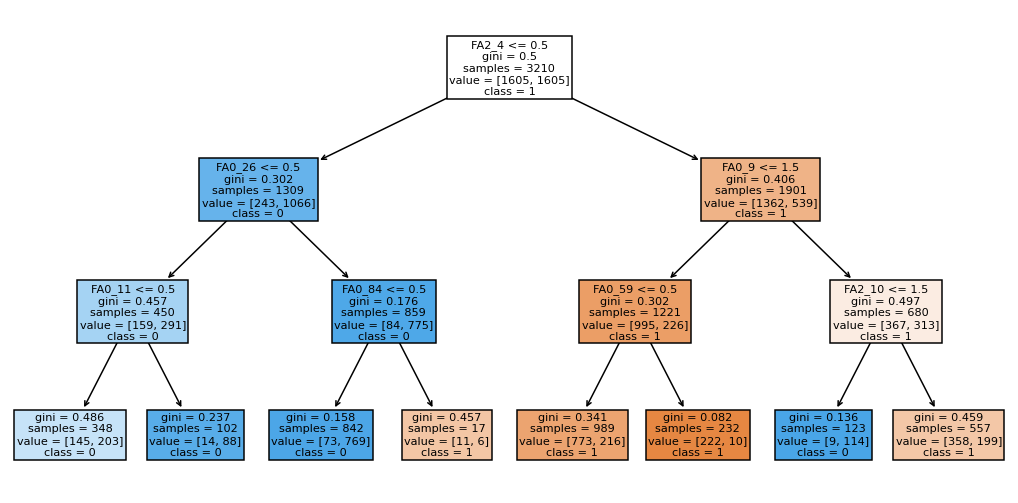

In [12]:
test_kernel(selected_graphs, "FA", 2, "dead")

Note: For the sake of brevity, the decision tree presented in [our paper](https://arxiv.org/abs/2010.10343) (Section 5, Figure 7) has been simplified for presentation from the full decision tree shown above. The simplification consisted in collapsing nodes in the bottom layer into nodes of the previous layer, suppressing Gini impurity measure information, changing threshold into integer values, and replacing value counts with percentages.

### Exploring the provenance types selected by the decision tree

The function `print_type_definition()` provides us with the type definitions associated with each of the provenance types, e.g. `FA2_4`, `FA0_26`, `FA0_9`, used in the trained decision tree. Their definitions allow us to describe them according to the events they encode.

In [13]:
print_type_definition(outputs_folder, "FA2_4")

[der|gen]→[der|gen|usd|waw]→[act|agt|ent|mimic:IntensiveCare|mimic:Patient|mimic:Treating|mimic:Ward]


In [14]:
print_type_definition(outputs_folder, "FA0_26")

[act|mimic:Performing|process:225792]


In [15]:
print_type_definition(outputs_folder, "FA0_9")

[act|mimic:IntensiveCare|mimic:Treating]


In [16]:
print_type_definition(outputs_folder, "FA2_10")

[usd]→[der|gen]→[act|ent|mimic:IntensiveCare|mimic:Patient|mimic:Treating]
